In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
from scipy import stats
import sys
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import axes, bundles

# Increase the resolution of all the plots below
bundles.beamer_moml()
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})

from utilities.utl import remove_outliers_df


## set path and merge data

In [2]:
dir_script = Path("__file__").parent.absolute()
dir_plots = Path.joinpath(dir_script.parent.absolute(),"06_plots","02_group_comparisons")
dir_prep = Path.joinpath(dir_script.parent.absolute(),"04_data","01_prep")
print(dir_script)

dir_plots.mkdir(parents=False, exist_ok=True)

dat_pupil = pd.read_csv(Path.joinpath(dir_prep,"all_trials_pupil.csv"), index_col=False)
dat_gss = pd.read_csv(Path.joinpath(dir_prep,"all_trials_gss.csv"), index_col=False)

list(dat_pupil.columns)

c:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


['ID',
 'Trial n',
 'Feedback type',
 'Feedback angle',
 'Pupil size',
 'Percentage bad pupil samples',
 'Group']

In [3]:
full = pd.merge(dat_gss, dat_pupil, on=["ID","Trial n","Group","Feedback type","Feedback angle"])
full = full.loc[:,~full.columns.str.startswith('Unnamed')]
list(full.columns)

['ID',
 'Trial n',
 'Feedback type',
 'Feedback angle',
 'Power [4-12]',
 'Power [1-3]',
 'Group',
 'Pupil size',
 'Percentage bad pupil samples']

## filter data for t-tests

In [4]:
tt = full.copy()
cfg_out_ppl_per = 40

tt = tt.loc[tt["Percentage bad pupil samples"] < cfg_out_ppl_per,:]

### clean from bad pupil data and run test for each group for each condition

In [5]:
pat = tt.groupby("Group").get_group("p")

ppl_ao_high = pat.loc[(pat["Feedback angle"] == "high") & (pat["Feedback type"] == "ao"),"Pupil size"]
ppl_ao_low = pat.loc[(pat["Feedback angle"] == "low") & (pat["Feedback type"] == "ao"),"Pupil size"]
t_ao, p_ao = stats.mannwhitneyu(ppl_ao_high,ppl_ao_low)

ppl_va_high = pat.loc[(pat["Feedback angle"] == "high") & (pat["Feedback type"] == "va"),"Pupil size"]
ppl_va_low = pat.loc[(pat["Feedback angle"] == "low") & (pat["Feedback type"] == "va"),"Pupil size"]
t_va, p_va = stats.mannwhitneyu(ppl_va_high,ppl_va_low)

ppl_vo_high = pat.loc[(pat["Feedback angle"] == "high") & (pat["Feedback type"] == "vo"),"Pupil size"]
ppl_vo_low = pat.loc[(pat["Feedback angle"] == "low") & (pat["Feedback type"] == "vo"),"Pupil size"]
t_vo, p_vo = stats.mannwhitneyu(ppl_vo_high,ppl_vo_low)

print(f'High-low differences for patients for visual only condition is p:{p_ao:.3f}')
print(f'High-low differences for patients for visual-auditive condition is p:{p_va:.3f}')
print(f'High-low differences for patients for auditiv only condition is p:{p_vo:.3f}')

High-low differences for patients for visual only condition is p:0.163
High-low differences for patients for visual-auditive condition is p:0.301
High-low differences for patients for auditiv only condition is p:0.197


In [6]:
hc = tt.groupby("Group").get_group("c")

ppl_ao_high = hc.loc[(hc["Feedback angle"] == "high") & (hc["Feedback type"] == "ao"),"Pupil size"]
ppl_ao_low = hc.loc[(hc["Feedback angle"] == "low") & (hc["Feedback type"] == "ao"),"Pupil size"]
t_ao, p_ao = stats.mannwhitneyu(ppl_ao_high,ppl_ao_low)

ppl_va_high = hc.loc[(hc["Feedback angle"] == "high") & (hc["Feedback type"] == "va"),"Pupil size"]
ppl_va_low = hc.loc[(hc["Feedback angle"] == "low") & (hc["Feedback type"] == "va"),"Pupil size"]
t_va, p_va = stats.mannwhitneyu(ppl_va_high,ppl_va_low)

ppl_vo_high = hc.loc[(hc["Feedback angle"] == "high") & (hc["Feedback type"] == "vo"),"Pupil size"]
ppl_vo_low = hc.loc[(hc["Feedback angle"] == "low") & (hc["Feedback type"] == "vo"),"Pupil size"]
t_vo, p_vo = stats.mannwhitneyu(ppl_vo_high,ppl_vo_low)

print(f'High-low differences for controls for visual only condition is p:{p_ao:.3f}')
print(f'High-low differences for controls for visual-auditive condition is p:{p_va:.3f}')
print(f'High-low differences for controls for auditiv only condition is p:{p_vo:.3f}')

High-low differences for controls for visual only condition is p:0.743
High-low differences for controls for visual-auditive condition is p:0.017
High-low differences for controls for auditiv only condition is p:0.050


## evaluate differences between angles and get correlation

In [7]:
cfg_out_ppl_per = 40
cr = full.copy()

cr = cr.loc[cr["Percentage bad pupil samples"] < cfg_out_ppl_per,:]
cr = cr[['ID','Group', 'Feedback type', 'Feedback angle','Power [4-12]','Pupil size']]


In [8]:
diffs = cr.pivot_table(index=['ID','Group','Feedback type'],columns='Feedback angle',values=['Power [4-12]','Pupil size'],margins=False,aggfunc='mean').reset_index()
diffs['dPower'] = diffs['Power [4-12]']['high']-diffs['Power [4-12]']['low']
diffs['dPpl'] = diffs['Pupil size']['high']-diffs['Pupil size']['low']
diffs = remove_outliers_df(diffs,['dPower'],1)
diffs['dPower'] = abs(diffs['dPower'])

Working on column: dPower


In [9]:
df_vo = len(diffs['Feedback type'] == 'vo')
df_va = len(diffs['Feedback type'] == 'va')
df_ao = len(diffs['Feedback type'] == 'ao')

t_pow_vo, p_pow_vo = stats.mannwhitneyu(diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for tremor is t[{df_vo}]={t_pow_vo:.2f}, p:{p_pow_vo:.3f}')
t_pow_av, p_pow_av = stats.mannwhitneyu(diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for tremor is t[{df_va}]={t_pow_av:.2f}, p:{p_pow_av:.3f}')
t_pow_ao, p_pow_ao = stats.mannwhitneyu(diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for tremor is t[{df_ao}]={t_pow_ao:.2f}, p:{p_pow_ao:.3f}')



Differences for group deltas in visual only for tremor is t[53]=39.00, p:0.078
Differences for group deltas in visual only for tremor is t[53]=67.00, p:0.041
Differences for group deltas in visual only for tremor is t[53]=40.00, p:0.130


<AxesSubplot:>

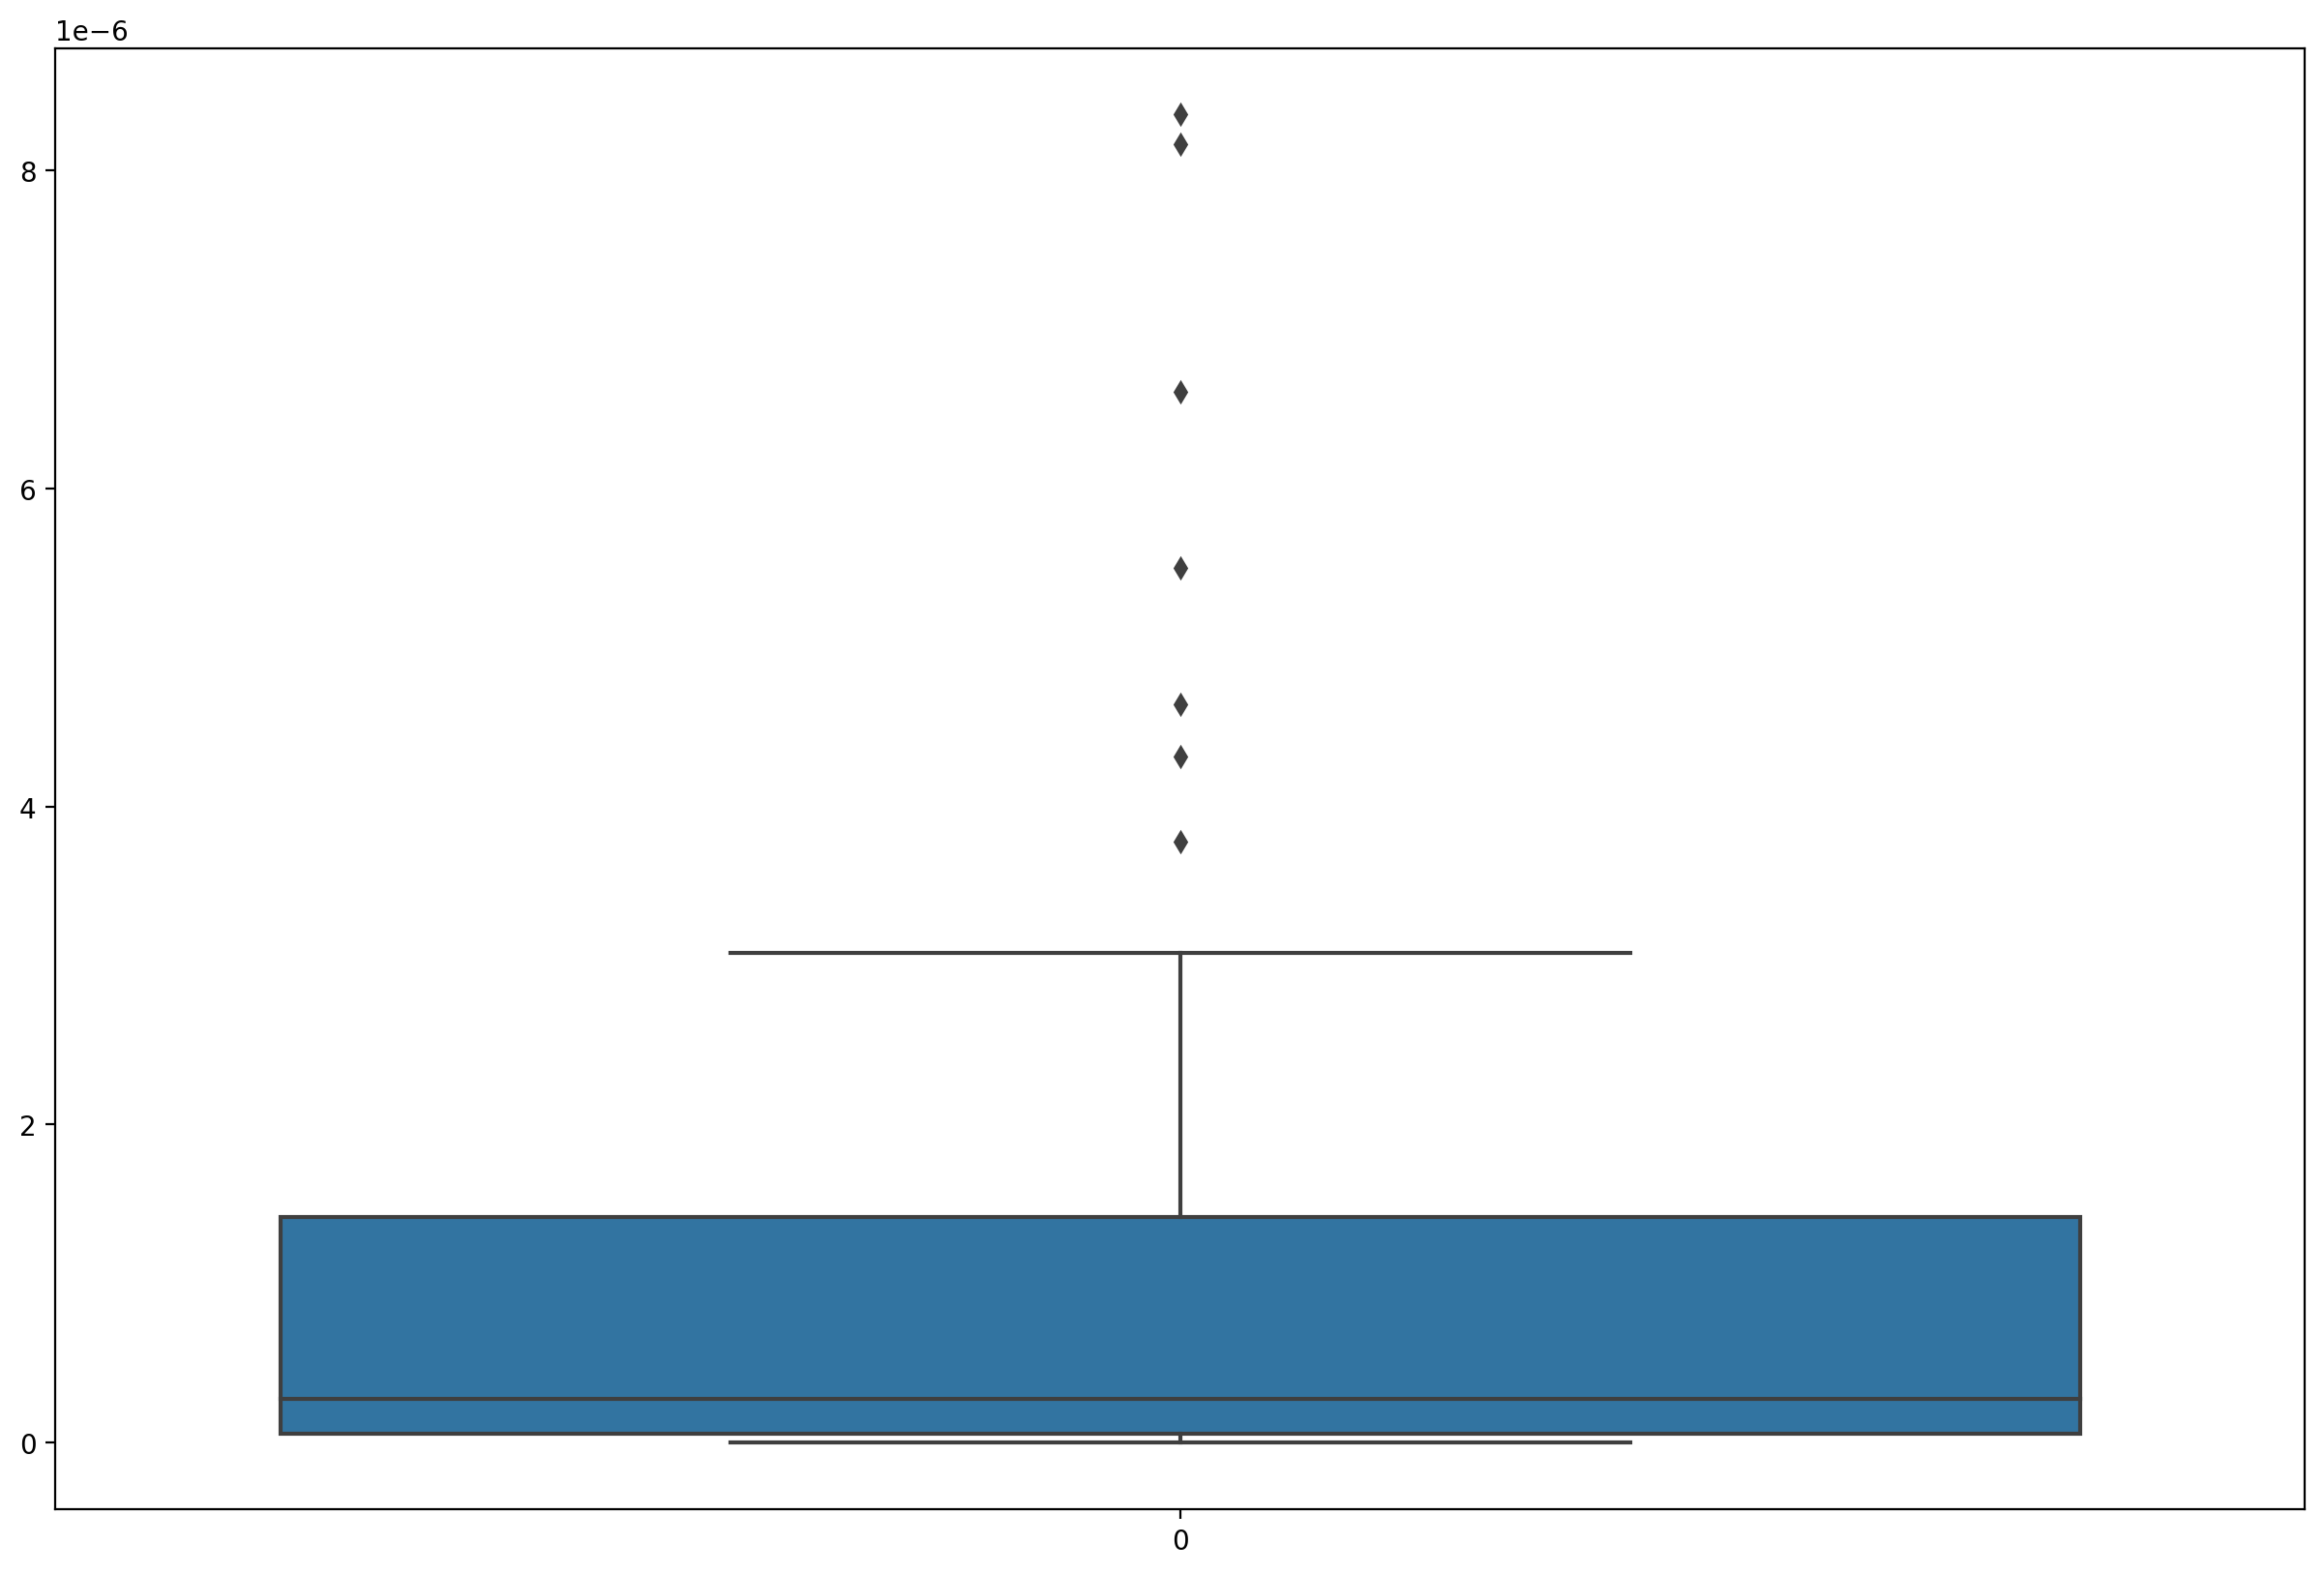

In [10]:
sns.boxplot(diffs['dPower'])

In [11]:
t_ppl_vo, p_ppl_vo = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for tremor is t[{df_vo}]={t_ppl_vo:.2f}, p:{p_ppl_vo:.3f}')
t_ppl_av, p_ppl_av = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for tremor is t[{df_va}]={t_ppl_av:.2f}, p:{p_ppl_av:.3f}')
t_ppl_ao, p_ppl_ao = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for tremor is t[{df_ao}]={t_ppl_ao:.2f}, p:{p_ppl_ao:.3f}')



Differences for group deltas in visual only for tremor is t[53]=36.00, p:0.170
Differences for group deltas in visual only for tremor is t[53]=54.00, p:0.353
Differences for group deltas in visual only for tremor is t[53]=32.00, p:0.549


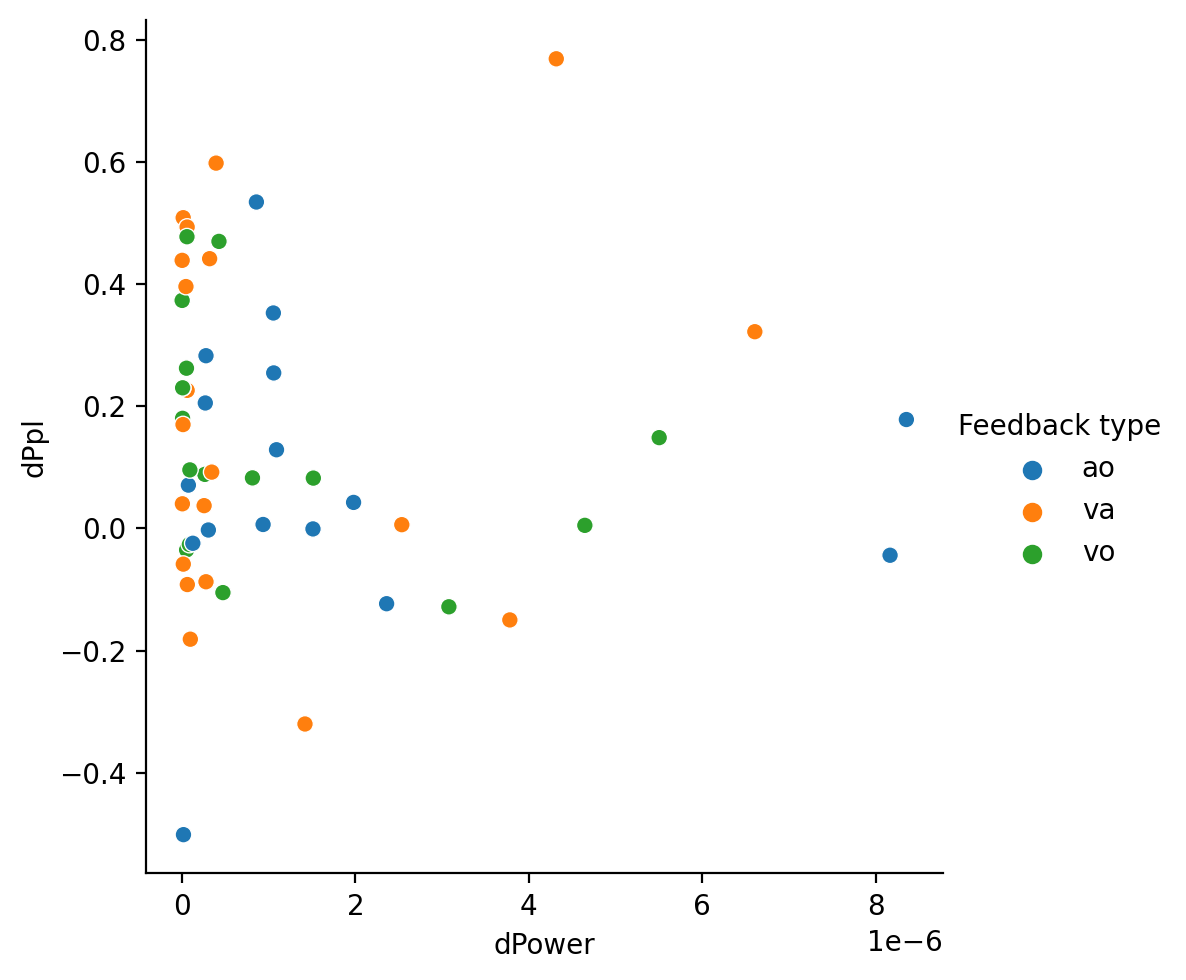

In [12]:
sns.relplot(
        data=diffs,x='dPower',y='dPpl',
        hue='Feedback type'
    )

<AxesSubplot:xlabel='Feedback type', ylabel='dPower'>

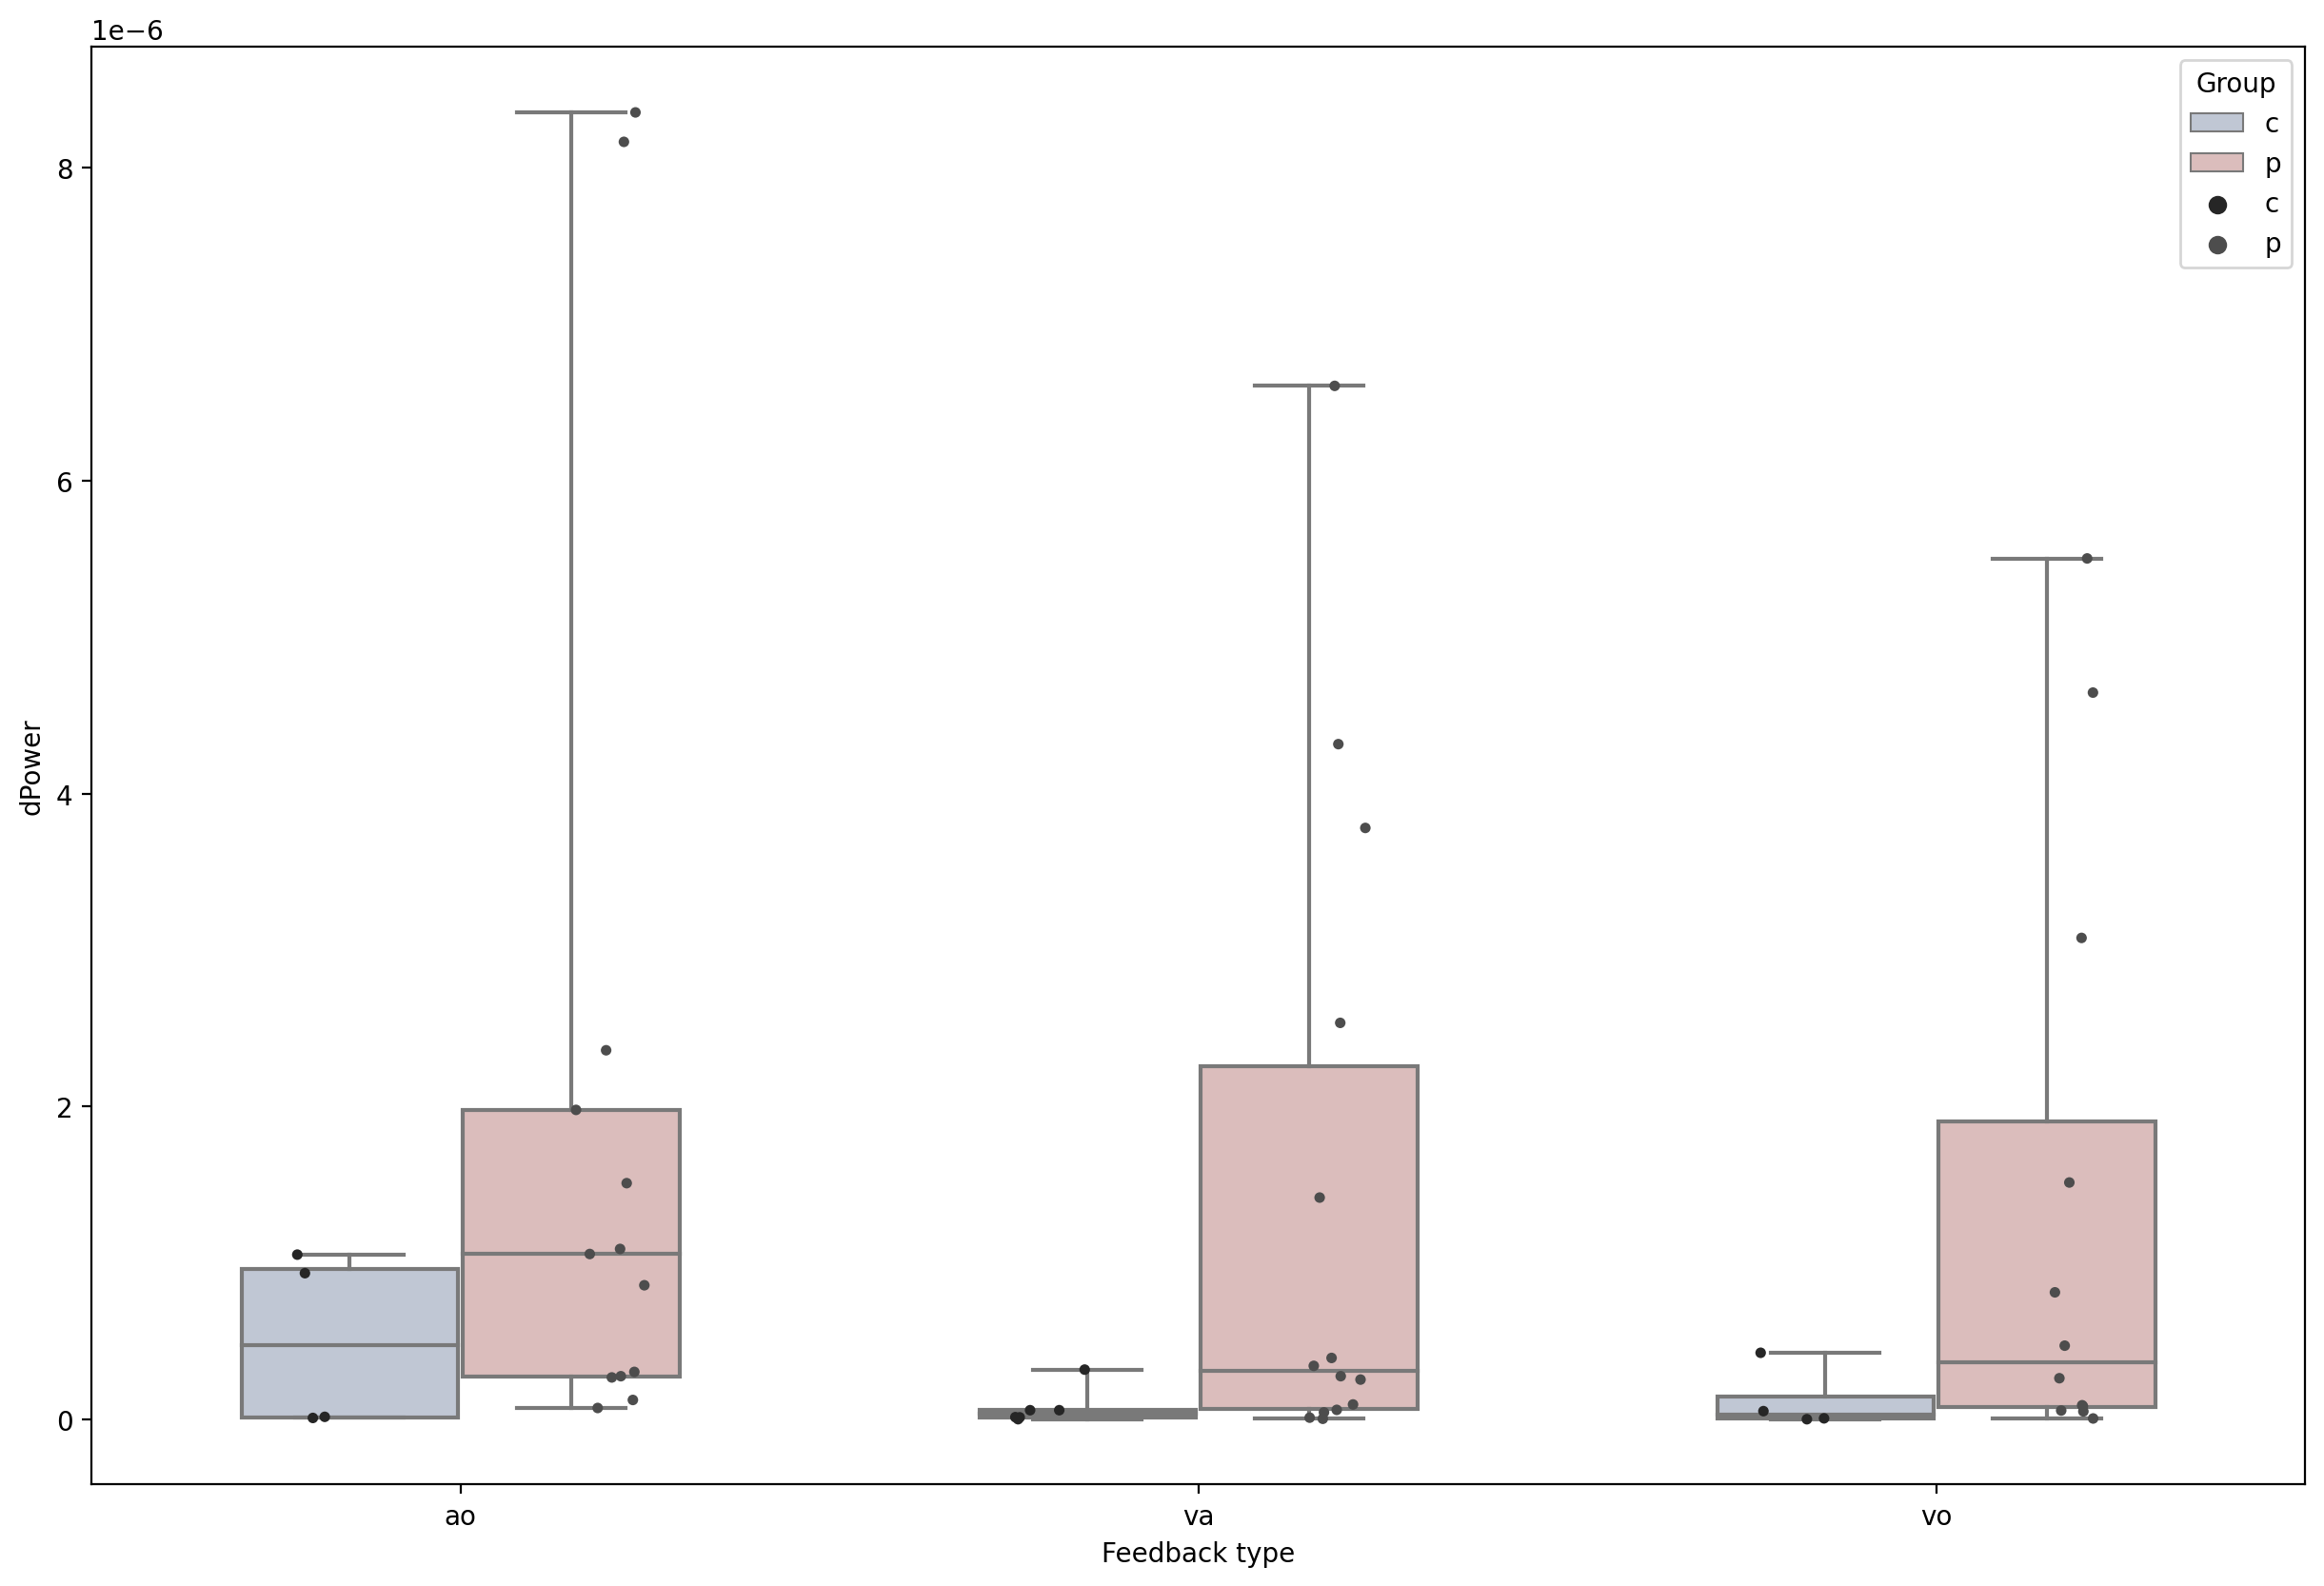

In [13]:
sns.boxplot(data = diffs, x = 'Feedback type', y = 'dPower', hue='Group',whis=[0, 100], width=.6,palette="vlag")
sns.stripplot(data = diffs, x = 'Feedback type', y = 'dPower', hue='Group',size=4, color=".3", linewidth=0,dodge=True)

<AxesSubplot:xlabel='dPower', ylabel='Count'>

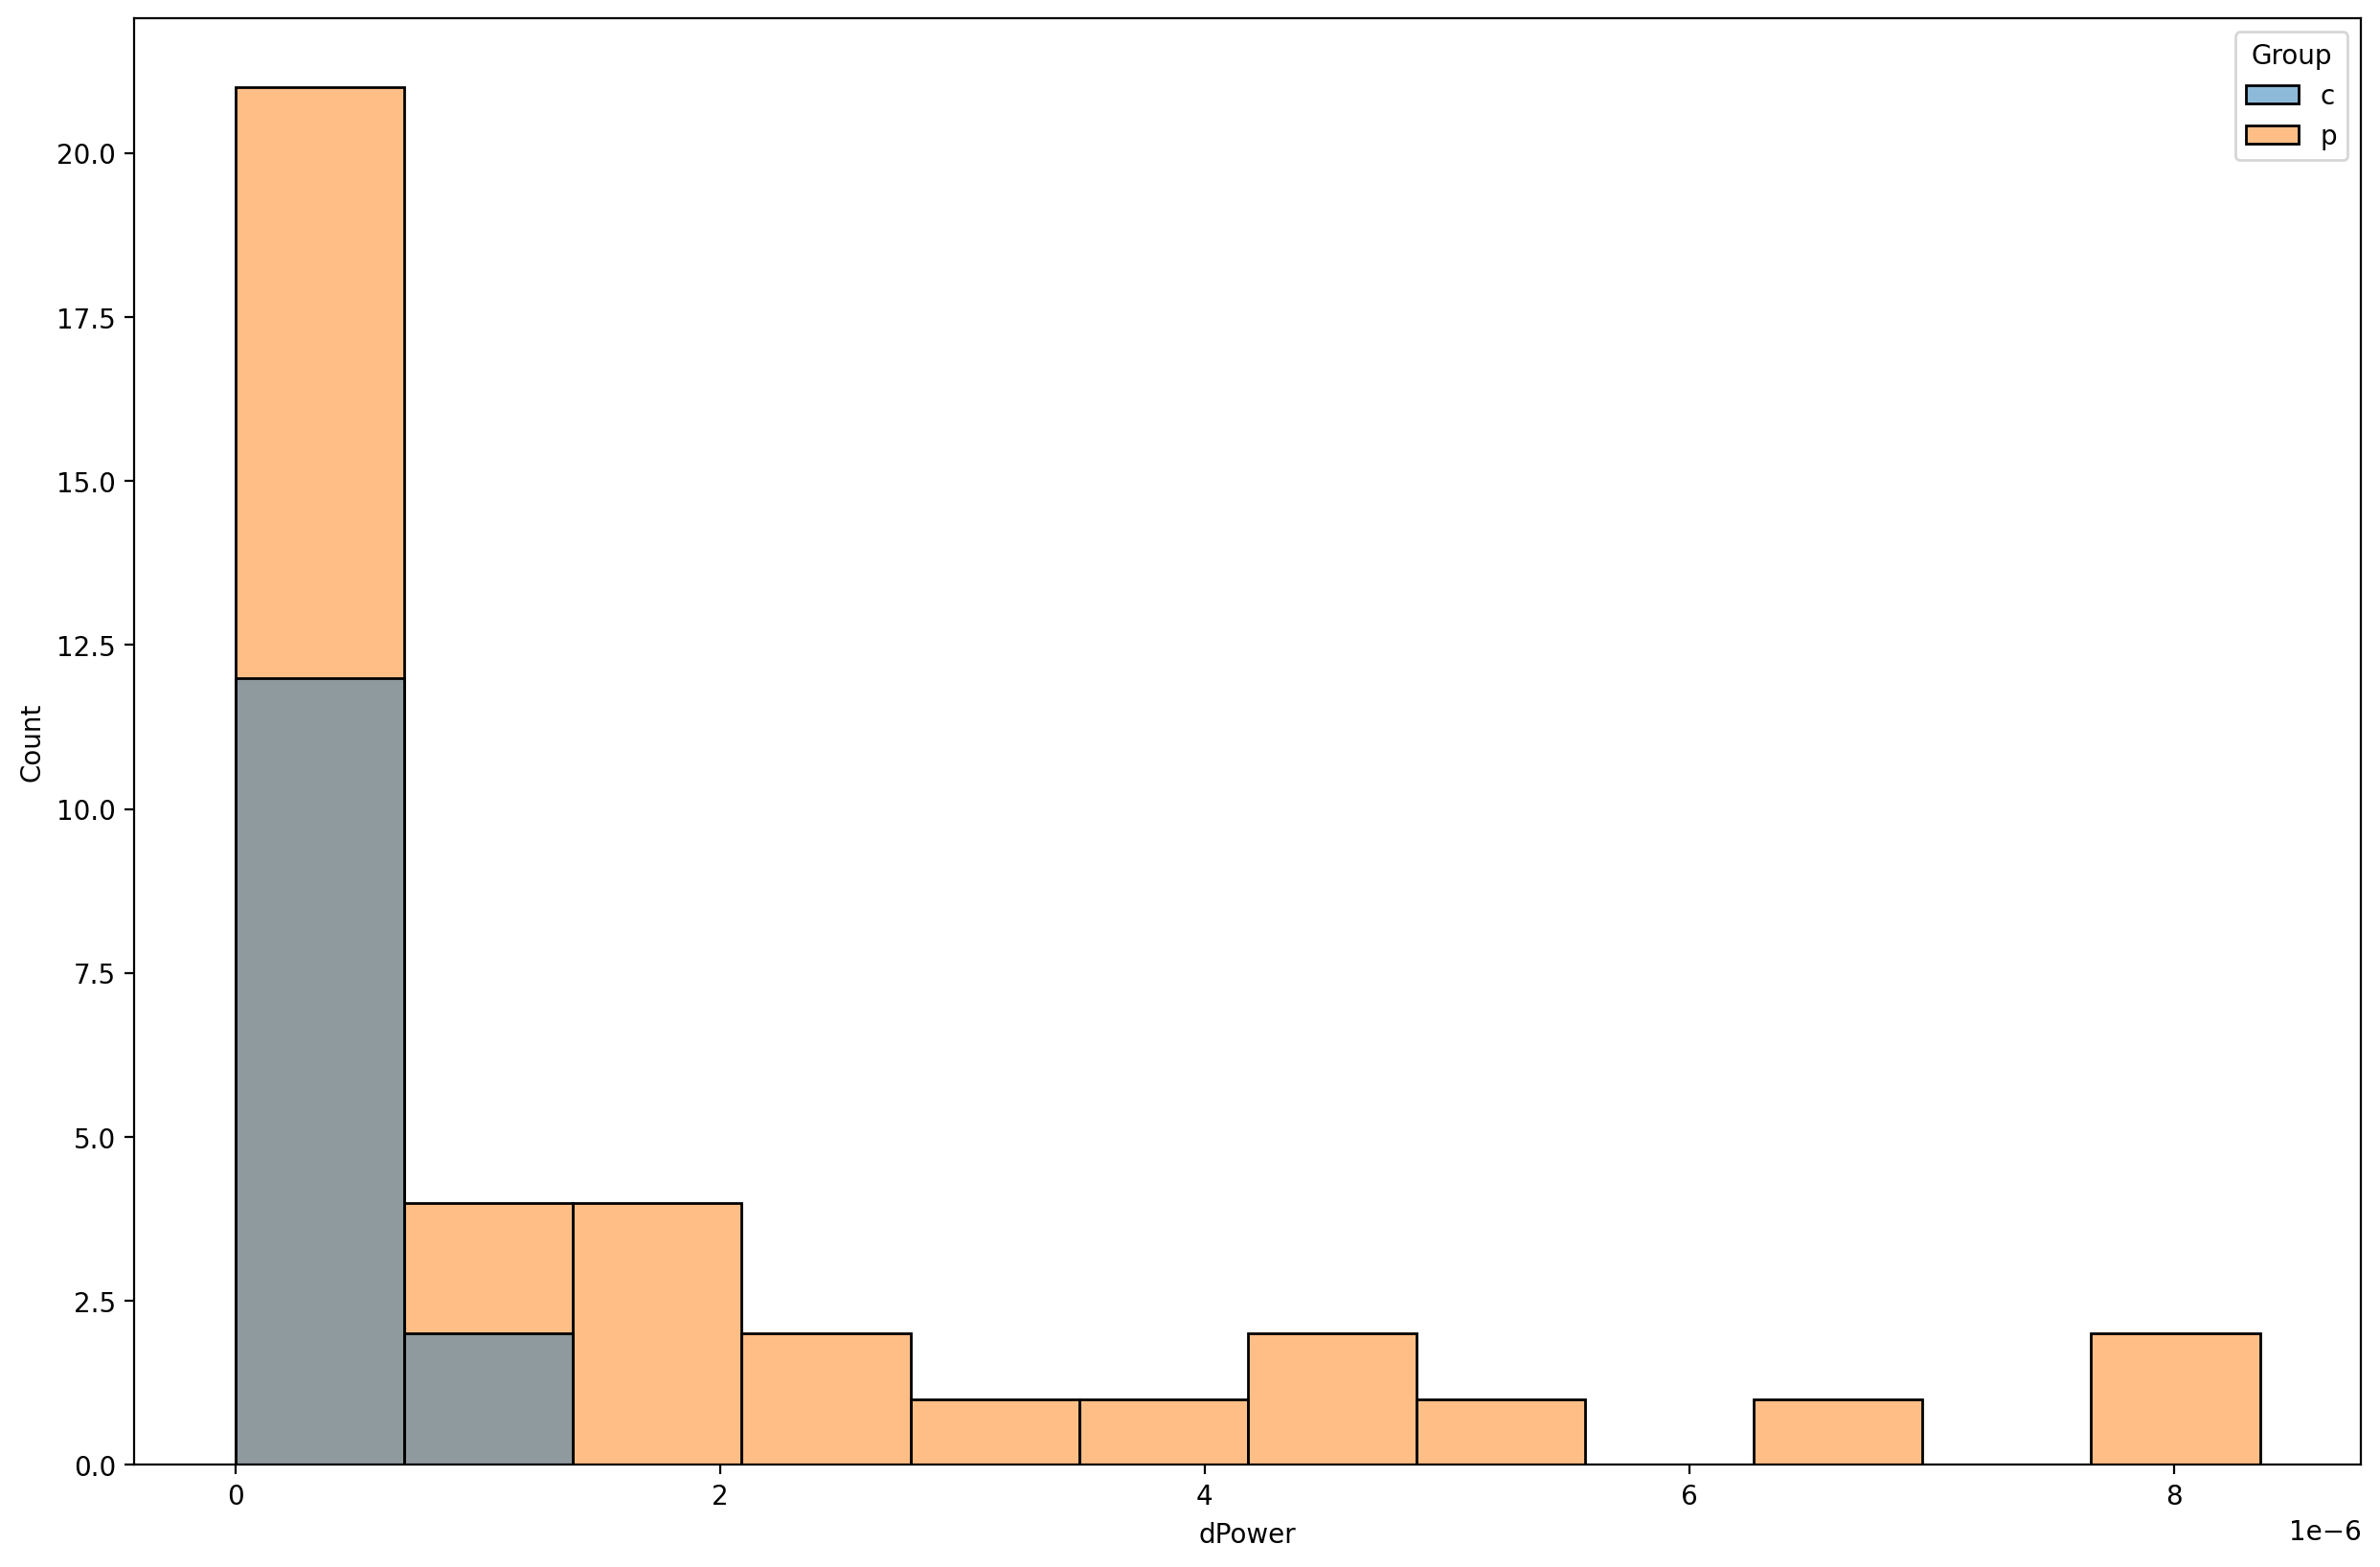

In [14]:
from tokenize import group


sns.histplot(data = diffs,x = 'dPower', hue='Group')